## Приоритизация гипотез и анализ A/B-теста

Приоритизация гипотез, запуск A/B-тест и анализ результата с целью увеличения выручки интернет магазина. 


## Описание данных

Таблица `hypothesi_data` (информация о гипотизах):

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Таблица `orders_data` (информация о заказах):

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Таблица `visitors_data` (инмормация о посещениях):

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка данных и их изучение

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
hypothesi_data = pd.read_csv('/datasets/hypothesis.csv')
orders_data = pd.read_csv('/datasets/orders.csv')
visitors_data = pd.read_csv('/datasets/visitors.csv')

In [3]:
display(hypothesi_data)
hypothesi_data.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
display(orders_data)
orders_data.info()
orders_data[orders_data.duplicated(keep = False)].sort_values(by = orders_data.columns.values.tolist())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group


In [5]:
display(visitors_data)
visitors_data.info()
visitors_data[visitors_data.duplicated(keep = False)].sort_values(by = visitors_data.columns.values.tolist())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors


### Вывод

Мы импортировали cvs файлы, нужные нам библиотеки и метод `display` для вывода на печать таблиц. Мы имеем три таблицы с разным количеством строк и столбцов. Пропуска в таблицах отсутствуют, дубликаты тоже. Есть небольшие замечания с типом данных со столбцами с датами. В таблице `hypothesi_data` было бы не плохо привести названия столбцов к нижнему регистру, чтобы избежать опечаток и ускорить процесс написания кода. Для дальнейшего анализа, проведении А/В тестов и визуализации все столбцы несут свою определенную ценность.

## Часть 1. Приоритизация гипотез.

### Задача 1. Применение фреймворка ICE для приоритизации гипотез.

In [6]:
# преобразуем названия столбцов к нижнему регистру
hypothesi_data.columns = hypothesi_data.columns.str.lower()

<div class="alert alert-block alert-info">
<br>

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
</div>

In [7]:
#расчет ice
hypothesi_data['ice'] = hypothesi_data['impact'] * hypothesi_data['confidence']/hypothesi_data['efforts']

pd.options.display.max_colwidth = 150
display(hypothesi_data.sort_values(by='ice', ascending=False)[['hypothesis', 'ice']])

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


### Вывод

Наиболее перспективные гипотезы по ICE: 8 (запуск скидки на День Рождение), 0 (Добавление двух новых канала привлечения трафика) и 7 (Добавление формы подписки на все основные страницы). Главное это как точно оценивают параметры, а не метод проверки приоритизации, поэтому стоит еще проверить RICE и посмотреть на гипотезы в нем. 

### Задача 2. Примениие фреймворка RICE для приоритизации гипотез.

In [8]:
hypothesi_data['rice'] =\
hypothesi_data['reach'] * hypothesi_data['impact'] * hypothesi_data['confidence']/hypothesi_data['efforts']

display(hypothesi_data.sort_values(by='rice', ascending=False)[['hypothesis', 'rice']])

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Вывод

Наиболее перспективные гипотезы по RICE:  7 (Добавление формы подписки на все основные страницы), 2(добавление блоков рекомендаций товаров на сайт интернет магазина), 0 (Добавление двух новых канала привлечения трафика) и 6 (показ на главной странице баннеров с актуальными акциями и распродажами). При чем rice у гипотез № 0 и 6 одинаковый. 

Гипотеза №7 сильно перспективнее, так как в ней будут задействовано больше пользователей. Охват пользователей это также важный параметр при проведении АВ тестов.


### Задача 3. Произошло ли изменение приоритизации гипотез при применении RICE вместо ICE?

In [9]:
hypothesi_data['id'] = hypothesi_data.reset_index().index
display(hypothesi_data.sort_values(by='rice', ascending=False))


,hypothesis,reach,impact,confidence,efforts,ice,rice,id
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0,7
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0,2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0,0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0,6
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2,8
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0,5
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0,4


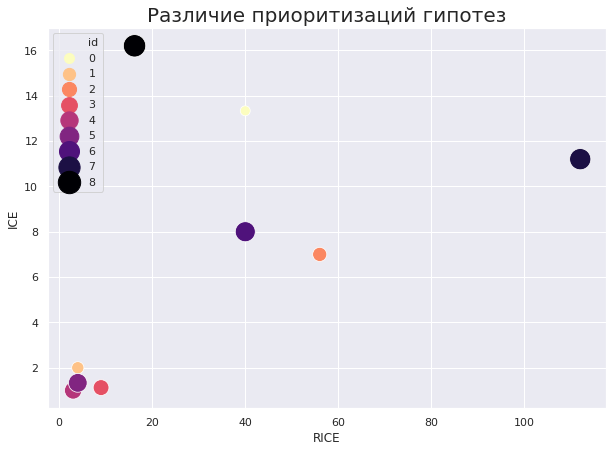

In [44]:
ax = plt.subplots(figsize=(10, 7))
sns.set(style = 'darkgrid', context='notebook')
sns.scatterplot(data=hypothesi_data, x="rice", y="ice", hue="id", size="id",sizes=(100, 500), legend="full", palette="magma_r")
plt.title("Различие приоритизаций гипотез", fontsize = 20)
plt.xlabel("RICE", fontsize = 12)
plt.ylabel("ICE", fontsize = 12)
plt.show()

### Вывод

Изменения в приоритетах гипотез между методами `ICE` и `RICE` произошли. На это повлиял параметр *reach*, который участвует в методе `RICE`. *reach* это охват аудитории. Уровень охвата измеряется количеством людей/событий за определенный период времени. Этот фактор предназначен для оценки того, на какое количество людей каждая гипотеза повлияет в течение определенного периода времени, и сколько наших пользователей увидят такие изменения. Этот показатель не менее важен, чем *impact, confidence или efforts*. 

Так допустим в гипотезе № 8, которая лидировала в ICE, в тесте будет участвовать минимальное количество людей, так как дни рождения распределены в течении года, а проводить А/В тест так долго - это очень затратно в труде, времени и деньгах. Поэтому в выборку попадет малое число пользователей. Хоть показатель *reach* очень низкий, но влияние на пользователей будет пред максимальным (показатель *impact*). Также мы уверены в своих оценках (показатель *confidence*) и трудозатрат не очень высокие (*efforts*). Поэтому в методе `ICE` это самая перспективная гипотеза, а в `RICE` не особо перспективная и находится в середине рейтинга из за малого охвата людей. 

В гипотезе № 7 которая в `RICE` занимает первое место, а в `ICE` только третье место, так сильно подскочила снова из- за показателя *reach*. Предполагается, что в данном А/В тесте будет охвачено максимальное кол-во пользователей за период проведения теста. 

По графику можно одновременно увидеть в каком месте приоритета находится та или иная гипотеза по двум проверяющим методам.


## Часть 2. Анализ A/B-теста.

###  Задача 1. График кумулятивной выручки по группам.

In [11]:
#Переводим столбце с датой в нужный тип данных
orders_data['date'] = pd.to_datetime(orders_data['date'])
visitors_data['date'] = pd.to_datetime(visitors_data['date'])

In [12]:
#Создадим массив уникальных пар значений дат и групп теста 
dates_groups = orders_data[['date','group']].drop_duplicates()

In [13]:
#получим агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(
    lambda x: orders_data[np.logical_and(orders_data['date'] <= x['date'], orders_data['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

display(orders_aggregated.head(10))

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996
499,2019-08-04,A,84,77,425699
498,2019-08-04,B,78,75,489567
698,2019-08-05,A,109,100,549917
699,2019-08-05,B,101,98,581995


In [14]:
#получим агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = dates_groups.apply(
lambda x: visitors_data[np.logical_and(visitors_data['date'] <= x['date'], visitors_data['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [15]:
# объединяем кумулятивные данные в одной таблице и переименуем названия столбцов
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head(10))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


In [16]:
# Создаем df с кумулятивным количеством заказов и кумулятивной выручкой по дням в разынх группах
cumulative_revenueA = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenueB = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

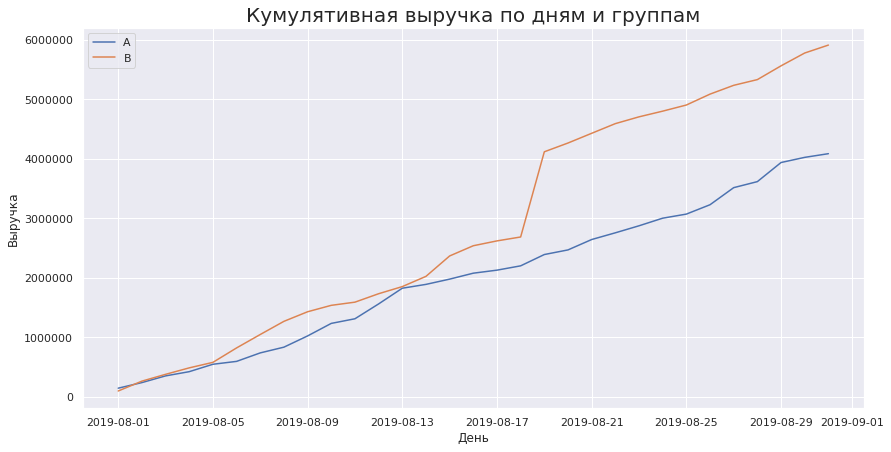

In [17]:
# строим график кумулятивной выручки по дням по группам
plt.figure(figsize=(14,7))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label='B')
plt.legend() 
plt.title("Кумулятивная выручка по дням и группам", fontsize = 20)
plt.xlabel("День", fontsize = 12)
plt.ylabel("Выручка", fontsize = 12)
plt.show()

### Вывод

Группа В лидировала на протяжении всего теста, а в середине теста вовсе вырвалась вперед еще сильнее. Графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа покупок, либо о появлении дорогих заказов в выборке. А в середине теста вовсе группа B предположительно купила ОЧЕНЬ дорогие заказы - рост очень резкий. Такие аномальные заказы при заключительном анализе попробуем убрать. 

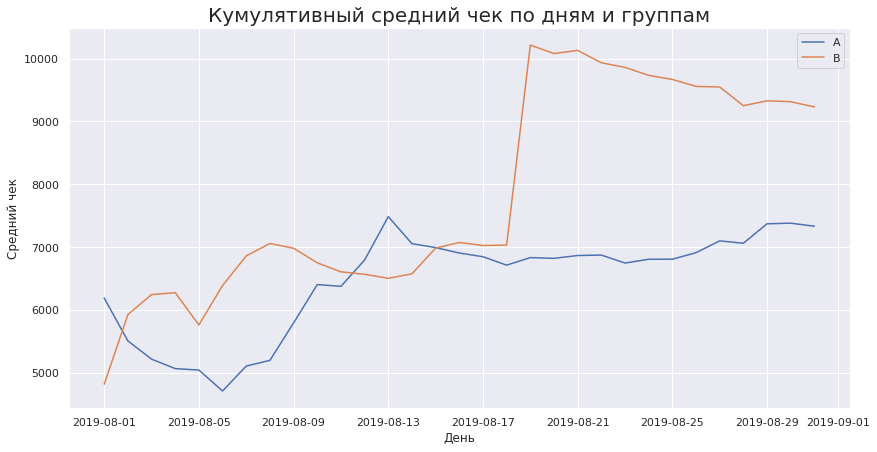

In [18]:
plt.figure(figsize=(14,7))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label='A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label='B')
plt.legend() 
plt.title("Кумулятивный средний чек по дням и группам", fontsize = 20)
plt.xlabel("День", fontsize = 12)
plt.ylabel("Средний чек", fontsize = 12)
plt.show()

### Вывод

Кумулятивное значения среднего чека на графике сильно колеблются. В группе А после середины теста средний чек становится равномернее чем в группе В, но все равно, скорее всего принимать решения по этой метрике рано, нужно еще время для проведения теста. 

Кстати в группе В мы были правы, в середине теста были произведены дорогие покупки в одном чеке, это видно по очень резкому росту 18 августа, как и на графике выручки.


###  Задача 3. График относительного изменения кумулятивного среднего чека группы B к группе A

In [19]:
# объединим предыдущие наши данные
merge_сumulative_revenue = cumulative_revenueA\
.merge(cumulative_revenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

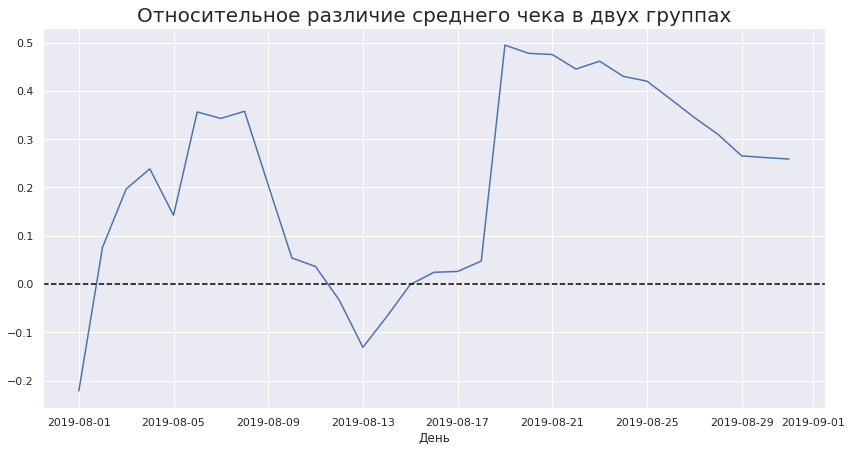

In [20]:
#Строим график
plt.figure(figsize=(14,7))
plt.plot(merge_сumulative_revenue['date'],\
(merge_сumulative_revenue['revenueB']/merge_сumulative_revenue['ordersB'])/
         (merge_сumulative_revenue['revenueA']/merge_сumulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.title("Относительное различие среднего чека в двух группах", fontsize = 20)
plt.xlabel("День", fontsize = 12)
plt.show()

### Вывод

Результаты теста резко меняются, плавных движений на графике мало. Значит крупных заказов и выбросов в данных предостаточно. Уберем их в последующих шагах, а сейчас посмотрим конверсию.

###  Задача 4. График кумулятивной конверсии по группам

In [21]:
#Cчитаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_dataA = cumulative_data[cumulative_data['group']=='A']
cumulative_dataB = cumulative_data[cumulative_data['group']=='B']

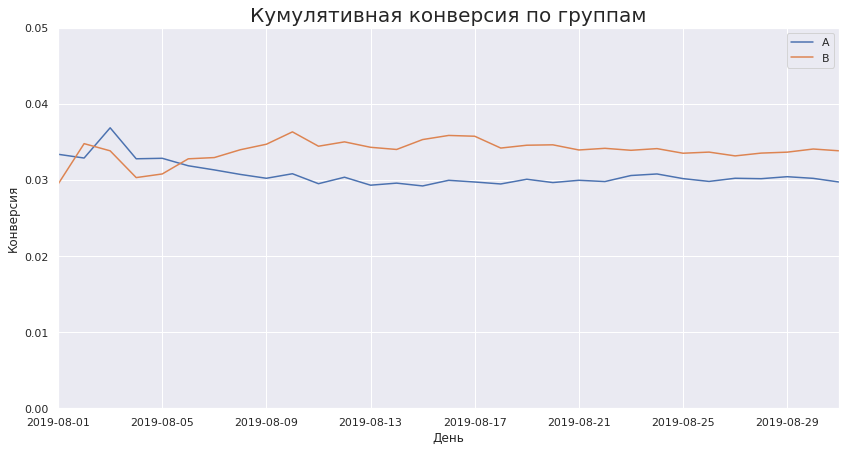

In [22]:
plt.figure(figsize=(14,7))
plt.plot(cumulative_dataA['date'], cumulative_dataA['conversion'], label='A')
plt.plot(cumulative_dataB['date'], cumulative_dataB['conversion'], label='B')
plt.legend()
plt.title("Кумулятивная конверсия по группам", fontsize = 20)
plt.xlabel("День", fontsize = 12)
plt.ylabel("Конверсия", fontsize = 12)
plt.axis(["2019-08-01", '2019-08-31', 0, 0.05]) 
plt.show()

### Вывод

Мы построили график кумулятивной конверсии по двум группам. Также мы изменили размер, теперь скачки выглядят нагляднее и правильнее. Так как скачок менее чем на одну сотую не нужно считать большим, он минимальный. 

В начале теста видны скачки острой формы, думаем, что этот эффект от того, что достаточные данные еще не успели накопиться.

Группа В на протяжении всего теста имеет большую конверсию перед группой А. 

После середины теста обе группы выровнялись и почти не меняют значение конверсии. Каждая группа зафиксировалась около одного значения.


###  Задача 5. График относительного изменения кумулятивной конверсии группы B к группе A. 

In [23]:
# объединим предыдущие данные
merge_сumulative_сonversions = cumulative_dataA[['date','conversion']]\
.merge(cumulative_dataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


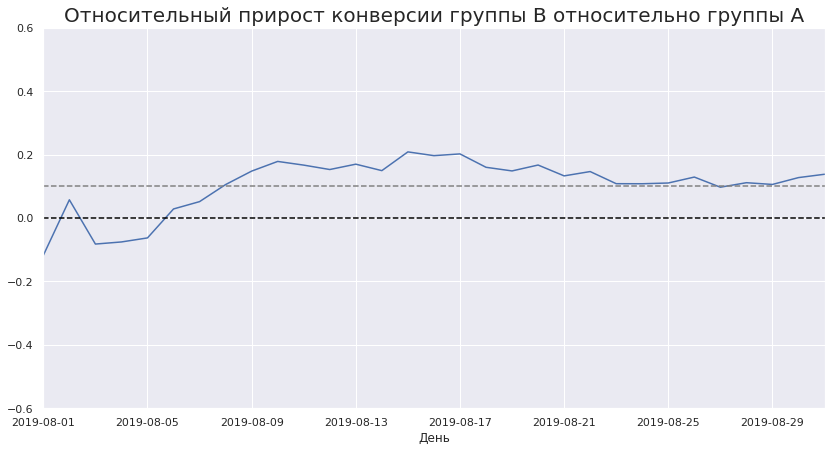

In [24]:
#Строим график
plt.figure(figsize=(14,7))
plt.plot(merge_сumulative_сonversions['date'], merge_сumulative_сonversions['conversionB']/
         merge_сumulative_сonversions['conversionA']-1)
plt.title("Относительный прирост конверсии группы B относительно группы A", fontsize = 20)
plt.xlabel("День", fontsize = 12)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.6, 0.6]) 
plt.show()

### Вывод

График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют небольшую тенденцию к росту, либо зафиксировались около среднего значения.

Серая пунктирная линия для наглядности показывает в каком месте график начинает стабилизироваться и уходить в боковик.


###  Задача 6. Точечный график количества заказов по пользователям.

In [25]:
# создадим таблицу с кол-вом заказов
orders_cnt = orders_data.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False)\
.agg({'transactionId' : pd.Series.nunique})

orders_cnt.columns = ['user_id','orders']
display(orders_cnt.sort_values(by='orders',ascending=False).head(10))

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


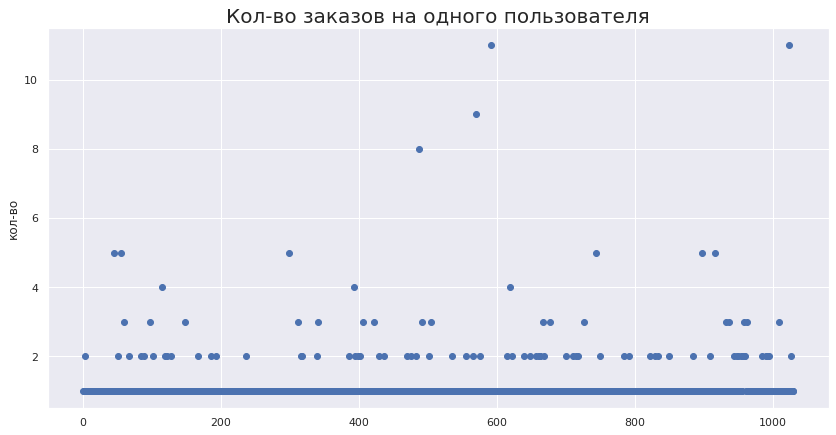

In [26]:
# строим график
x_values = pd.Series(range(0,len(orders_cnt)))
plt.figure(figsize=(14,7))
plt.scatter(x_values, orders_cnt['orders']) 
plt.title("Кол-во заказов на одного пользователя", fontsize = 20)
plt.ylabel("кол-во", fontsize = 12)
plt.show()

### Вывод

Пользователей, заказавших заказ более двух раз совсем мало, при этом число доходит даже до 11 заказов на одного. Нужно посчитать процентели, чтобы определиться два заказа это мало или много, тем самым понять где порог у выбросов.

###  Задача 7. Считаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [27]:
print(np.percentile(orders_cnt['orders'], [95, 99]))


[2. 4.]


### Вывод

Не более 5% пользователей совершали заказ больше двух раз. И 1% пользователей совершали заказ более четырех раз. Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.  

###  Задача 8. Строим точечный график стоимостей заказов.

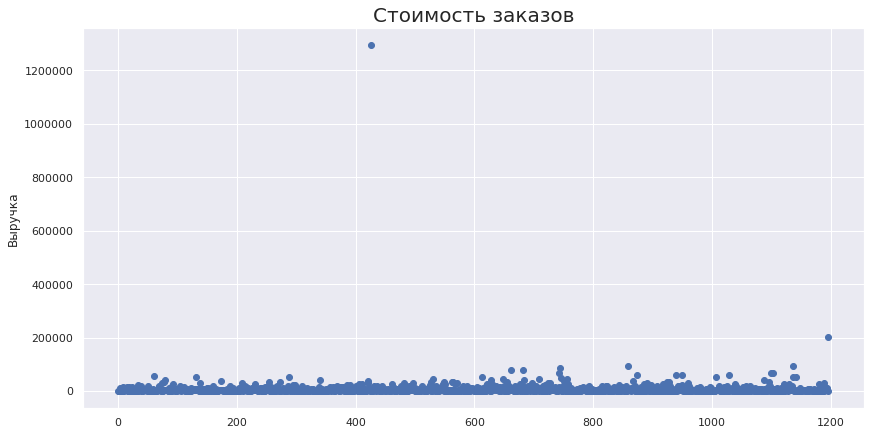

In [28]:
x_values = pd.Series(range(0,len(orders_data['revenue'])))
plt.figure(figsize=(14,7))
plt.scatter(x_values, orders_data['revenue']) 
plt.title("Стоимость заказов", fontsize = 20)
plt.ylabel("Выручка", fontsize = 12)
plt.show()

### Вывод

Заказов стоимость выше 50 тысяч совсем мало, есть заказ на 200 тысяч и целый один заказ на 1 млн 200 тысяч, вот он, то точно выброс! Думаем из-за него был такой скачок 18 августа на графиках среднего чека ранее. Посчитаем процетели, чтобы определить, что делать с другими заказами.

###  Задача 9. Считаем 95-й и 99-й перцентили стоимости заказов.

In [29]:
print(np.percentile(orders_data['revenue'], [95, 99]))

[28000.  58233.2]


### Вывод

Не более 5% пользователей совершают заказ дороже 28000 тысяч рублей. И не более 1% совершают заказ дороже 58233 рублей. Думаем порог к выбросам нужно установить на уровне 30000 тысяч рублей. 

###  Задача 10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. 

In [30]:
#Вспомним наши изначальные таблицы
display(orders_data.head(5))
display(visitors_data.head(5))

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [31]:
#количество пользователей в выбранную дату в группах
visitorsADaily = visitors_data[visitors_data['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors_data[visitors_data['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [32]:
#количество пользователей до выбранной даты включительно в группах
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]\
                                            .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [33]:
# количество заказов и сумарная выручка в группах
ordersADaily = orders_data[orders_data['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders_data[orders_data['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [34]:
# сумарная выручка и число заказов до выбранный даты включительно в группах. 

ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({'date' : 'max','ordersPerDateA' : 'sum','revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])

ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']


ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({'date' : 'max','ordersPerDateB' : 'sum','revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [35]:
# объеденим все таблицы в одну
total_data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

display(total_data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [36]:
# пользователи которые заказывали хотя бы 1 раз
ordersByUsersA = orders_data[orders_data['group']=='A'].groupby('visitorId', as_index=False)\
.agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders_data[orders_data['group']=='B'].groupby('visitorId', as_index=False)\
.agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders'] 


In [37]:
# пользователям с заказами будет соответствовать число заказов пользователя.

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(total_data['visitorsPerDateA']\
                                                .sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(total_data['visitorsPerDateB']\
                                                .sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 


In [38]:
import scipy.stats as stats
print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.2%}".format(sampleB.mean()/sampleA.mean()-1)) 


if stats.mannwhitneyu(sampleA, sampleB)[1] < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.00840
13.81%
Отвергаем нулевую гипотезу


### Вывод

Мы подготовили данные и применили тест Манна-Уитни. p-value получился меньше 0.05. Значит, отвергаем нулевую гипотезу. В конверсии между группами есть статистические значимые различия. Относительный прирост конверсии группы В к группе А равен 13,81%.

Нулевая гепотиза (H0) - отвергнута, конверсии между группами различаются.

### Задача 11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [39]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(orders_data[orders_data['group']=='A']['revenue']\
                                          , orders_data[orders_data['group']=='B']['revenue'])[1]))

print("{0:.2%}".format(orders_data[orders_data['group']=='B']['revenue']\
                       .mean()/orders_data[orders_data['group']=='A']['revenue'].mean()-1))

if stats.mannwhitneyu(orders_data[orders_data['group']=='A']['revenue']\
                                          , orders_data[orders_data['group']=='B']['revenue'])[1] < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.365
25.87%
Не получилось отвергнуть нулевую гипотезу


### Вывод

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нету. 
Впрочем, средний чек группы B значительно выше среднего чека группы A, почти на целых 26%. 

Альтернативная гепотиза (H1) - отвергнута, в среднем чеке различий нет.

### Задача 12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [40]:
#Узнаем наши аномалии/выбросы, вспомним наши процентели.
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId']\
                                 , ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders_data[orders_data['revenue'] > 30000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64
(68,)


In [41]:
#подготовим отчищенные выборки
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId']\
        .isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(total_data['visitorsPerDateA']\
                .sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId']\
        .isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(total_data['visitorsPerDateB']\
                .sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0) 

In [42]:
# Проводим тест
print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.2%}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

if stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < 0.05:                 
    print("Отвергаем нулевую гипотезу")
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.00667
17.16%
Отвергаем нулевую гипотезу


### Вывод

Как и в случае с сырыми данными, в отчищенных статистическая значимость также достигнута. p-value по-прежнему меньше 0.05.
При этом относительный прирост конверсии группы В к группе А стал еще больше и уже равен 17%. 

Нулевая гепотиза (H0) - отвергнута, конверсии между группами по очищенным данным различаются.

### Задача 13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [43]:
print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(orders_data[np.logical_and(orders_data['group']=='A'\
    ,np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue']\
        ,orders_data[np.logical_and(orders_data['group']=='B'\
            ,np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))


print("{0:.2%}".format(orders_data[np.logical_and(orders_data['group']=='B'\
    ,np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue']\
        .mean()/orders_data[np.logical_and(orders_data['group']=='A'\
            ,np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

if stats.mannwhitneyu(orders_data[np.logical_and(orders_data['group']=='A'\
    ,np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue']\
        ,orders_data[np.logical_and(orders_data['group']=='B'\
            ,np.logical_not(orders_data['visitorId'].isin(abnormalUsers)))]['revenue'])[1] < 0.05:                 
    print("Отвергаем нулевую гипотезу")
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.360
-2.31%
Не получилось отвергнуть нулевую гипотезу


### Вывод

P-value все по-прежнему значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нету. Но после очищения выбросов, средний чек группы B потерял лидерство над группой А в 26% и теперь уже группа А выше на 2.3%. 
Это показывает, как сильно могут влиять выбросы на результаты А/В тестов.

Альтернативная гепотиза (H1) - отвергнута, в среднем чеке различий нет. 

### Принимаем решение по результатам А/В теста.

Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. По сырым и отчищенным данным нет статистически значимого различия по среднему чеку между группами. График различия конверсии между группами сообщает, что результаты группы B лучше группы A. Но при этом график конверсии и тем более среднего чека, еще стойко не смогли зафиксироваться, но имеют к этому предрасположенность. В связи с этим принимаем решение продолжить тест, пока графики не займут боковой тренд, не выйдут на плато.